Week 6 · Day 5 — Deeper Architectures
Why this matters

Shallow nets (1–2 layers) can solve simple tasks. But deeper architectures:

Capture hierarchical features (edges → shapes → objects).

Are more expressive (universal approximation in practice).

Power modern AI (ResNet, GPT, etc.).

The challenge: deeper nets can be harder to train (vanishing gradients, overfitting, slow convergence). Initialization + BN (from Day 3) help solve this.

Theory Essentials

Shallow MLP: limited representation power.

Deeper nets: more layers → learn more complex decision boundaries.

Trade-offs:

Too shallow → underfit.

Too deep (without regularization) → overfit or unstable.

Solutions: He initialization, batch norm, dropout, skip connections (later in ResNets).

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


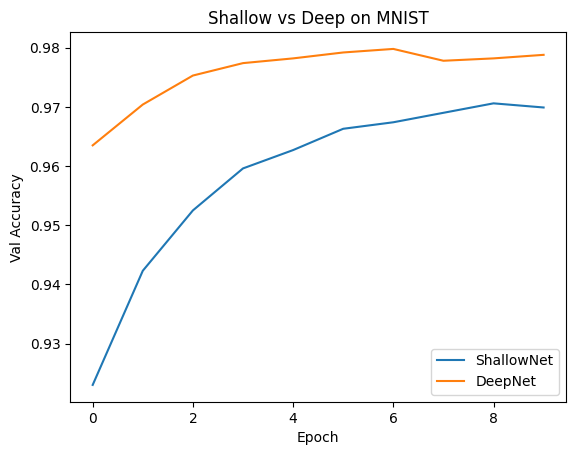

In [ ]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=1000)

# ---------- Models ----------
class ShallowNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm1d(512), nn.BatchNorm1d(256), nn.BatchNorm1d(128), nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        return self.fc5(x)

# ---------- Train/Eval ----------
def train_eval(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    val_accs=[]
    for epoch in range(epochs):
        model.train()
        for X,y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X),y)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        correct,total=0,0

        print("Epoch:", epoch + 1)
        with torch.no_grad():
            for X,y in val_loader:
                preds = model(X).argmax(1)
                correct += (preds==y).sum().item()
                total += y.size(0)
        val_accs.append(correct/total)
    return val_accs

shallow_accs = train_eval(ShallowNet(), epochs=10)
deep_accs    = train_eval(DeepNet(), epochs=10)

plt.plot(shallow_accs,label="ShallowNet")
plt.plot(deep_accs,label="DeepNet")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy")
plt.legend(); plt.title("Shallow vs Deep on MNIST")
plt.show()


1) Core (10–15 min)
Task: Train both nets for 10 epochs. Does DeepNet reach higher accuracy?

Deepnet reaches better accuracy

2) Practice (10–15 min)
Task: Add dropout (0.3) after each layer in DeepNet. Does it improve validation accuracy stability?

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


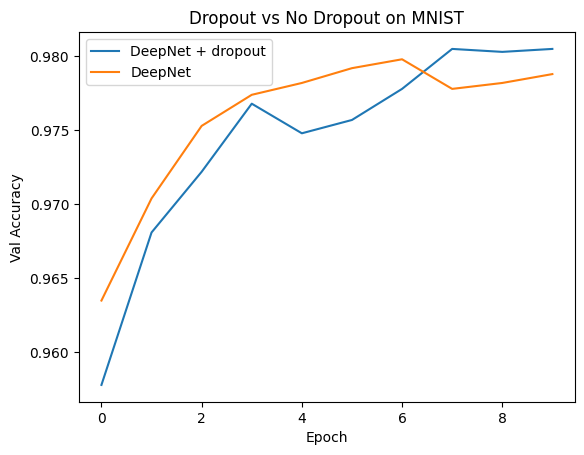

In [2]:
class DeepNet_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.drop3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, 64)
        self.drop4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm1d(512), nn.BatchNorm1d(256), nn.BatchNorm1d(128), nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.drop4(x)
        return self.fc5(x)
    

deep_accs_drop    = train_eval(DeepNet_dropout(), epochs=10)

plt.plot(deep_accs_drop,label="DeepNet + dropout")
plt.plot(deep_accs,label="DeepNet")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy")
plt.legend(); plt.title("Dropout vs No Dropout on MNIST")
plt.show()


3) Stretch (optional, 10–15 min)
Task: Modify DeepNet to use only 32 neurons per hidden layer but 8 layers deep. Compare accuracy with wide-but-shallow nets.

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


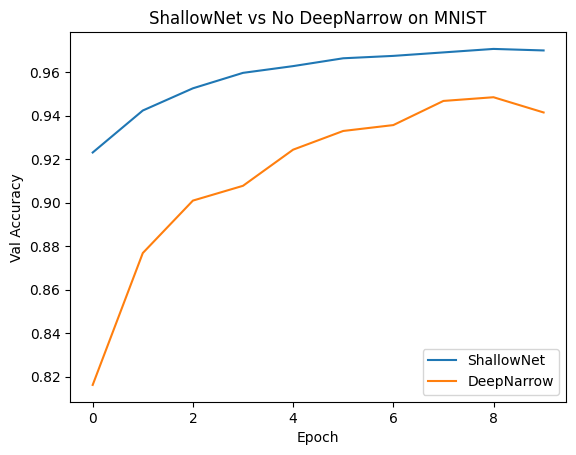

In [3]:
class DeepNarrowNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(28*28, 32),    # input → 32
            *[nn.Linear(32, 32) for _ in range(6)],  # 6 hidden layers of 32
            nn.Linear(32, 10)        # final layer → 10 classes
        ])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.hidden_layers[:-1]:
            x = self.relu(layer(x))
        return self.hidden_layers[-1](x)

deep_narrow    = train_eval(DeepNarrowNet(), epochs=10)

plt.plot(shallow_accs,label="ShallowNet")
plt.plot(deep_narrow,label="DeepNarrow")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy")
plt.legend(); plt.title("ShallowNet vs No DeepNarrow on MNIST")
plt.show()

Mini-Challenge (≤40 min)

Task: Design and train your own architecture on MNIST.

Choose width, depth, dropout.

Train 10 epochs.

Plot validation accuracy.
Acceptance Criteria:

Compare with baseline ShallowNet.

Brief 2–3 lines explaining why your design did better or worse.

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


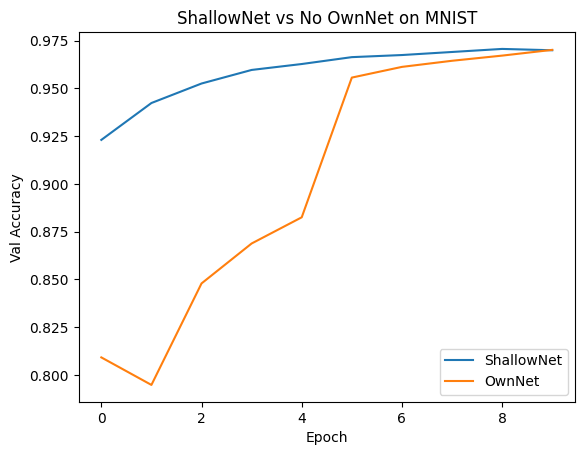

In [4]:
class OwnNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.drop4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, 64)
        self.drop5 = nn.Dropout(0.5)
        self.fc6 = nn.Linear(64, 32)
        self.drop6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.bn1, self.bn2, self.bn3, self.bn4, self.bn5, self.bn6 = nn.BatchNorm1d(512), nn.BatchNorm1d(256), nn.BatchNorm1d(128), nn.BatchNorm1d(64), nn.BatchNorm1d(64), nn.BatchNorm1d(32)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.drop4(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.drop5(x)
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.drop6(x)
        return self.fc7(x)
    


ownNet_accs    = train_eval(OwnNet(), epochs=10)

plt.plot(shallow_accs,label="ShallowNet")
plt.plot(ownNet_accs,label="OwnNet")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy")
plt.legend(); plt.title("ShallowNet vs No OwnNet on MNIST")
plt.show()

Stacking many 0.5 dropouts crushes signal → low val acc the first epochs.

BN’s running stats need a few updates; with heavy dropout they stabilize late → sudden improvement around epoch 5.

Notes / Key Takeaways

Depth = more representational power, but harder to train.

Shallow → underfit; deep → risk of overfit.

BatchNorm + He init stabilize deep training.

Dropout helps control overfitting in deeper nets.

Architecture choice is as important as optimizer.

Reflection

Why might a deeper net generalize better than a shallow one on MNIST?

Why can deeper nets sometimes perform worse if not regularized or initialized well?

1. Why might a deeper net generalize better than a shallow one on MNIST?

Deeper nets can learn hierarchical features: early layers detect edges/strokes, middle layers combine them into digit parts, and deeper layers assemble full digit concepts.

This richer representation often improves generalization compared to shallow nets that only learn simple patterns.

2. Why can deeper nets sometimes perform worse if not regularized or initialized well?

Without good initialization, signals may vanish or explode as they pass through many layers → gradients break.

Without regularization, deeper nets easily overfit (memorize training data) instead of generalizing.

So deeper nets need tools like He/Xavier init, BatchNorm, dropout, weight decay to train stably.